In [99]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("../../Downloads/AOD_series.csv")
data.head()

,Wk_1_2014,Wk_2_2014,Wk_3_2014,Wk_4_2014,Wk_5_2014,Wk_6_2014,Wk_7_2014,Wk_8_2014,Wk_9_2014,Wk_10_2014,...,Wk_44_2018,Wk_45_2018,Wk_46_2018,Wk_47_2018,Wk_48_2018,Wk_49_2018,Wk_50_2018,Wk_51_2018,Wk_52_2018,Wk_53_2018
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# remove rows with only NAs
data.dropna(axis=0, how="all", inplace=True)
data.head()

,Wk_1_2014,Wk_2_2014,Wk_3_2014,Wk_4_2014,Wk_5_2014,Wk_6_2014,Wk_7_2014,Wk_8_2014,Wk_9_2014,Wk_10_2014,...,Wk_44_2018,Wk_45_2018,Wk_46_2018,Wk_47_2018,Wk_48_2018,Wk_49_2018,Wk_50_2018,Wk_51_2018,Wk_52_2018,Wk_53_2018
422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.205000,NaN,0.184122,NaN,0.406391,0.136056,0.204676,NaN
423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.174868,NaN,0.405219,0.117110,0.197330,NaN
424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.090549,NaN,0.169360,NaN,0.396316,0.108810,0.174159,NaN
425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.100307,NaN,0.161345,NaN,0.371792,0.105233,0.143394,NaN
426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.108512,NaN,0.152003,NaN,0.310051,0.107123,0.125354,NaN


In [5]:
window_length = 10

There are 2 options for LSTM data: using a time series of each individual cell's data, or using a time series of rasters. By row, the data is already formatted for the former.  
As each column represents one raster time point, for the latter, we split the columns into rolling windows.

### Predicting whole rasters

In [4]:
windows = np.empty((data.shape[1] - window_length, window_length, data.shape[0]))
targets = np.empty((windows.shape[0], 1, data.shape[0]))

In [104]:
for i in tqdm(range(data.shape[1] - window_length)):
    # missing values filled with -1 for now
    windows[i, :, :] = np.array(data.iloc[:, i:(i + window_length)].fillna(-1)).transpose()
    targets[i, :, :] = np.array(data.iloc[:, i + window_length].fillna(-1)).transpose().reshape(1, targets.shape[2])

100%|██████████| 254/254 [00:00<00:00, 340.83it/s]


In [105]:
# check whether targets assigned correctly
all(windows[10, 0, :] == targets[0, 0, :])

True

In [106]:
# check whether window data assigned correctly
all(windows[window_length, 0, :] == np.array(data.iloc[:, window_length].fillna(-1)))

True

In [107]:
windows.shape # number of windows x window length x number of data points

(254, 10, 30310)

In [108]:
targets.shape

(254, 1, 30310)

In [109]:
model = Sequential()
model.add(LSTM(window_length, input_shape=(window_length, windows.shape[2])))
model.add(Dense(targets.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')

In [110]:
model.fit(windows, targets, epochs=1, batch_size=1)

254/254 [==============================] - 7s 24ms/step - loss: 0.3403


In [111]:
test_data = np.array(data.iloc[:, window_length].fillna(-1))
test_pred = model.predict(windows[0, :, :].reshape(1, window_length, 30310)).reshape(30310)

In [112]:
# add back empty observations
padded_data = np.full((59000), np.nan)
padded_pred = np.full((59000), np.nan)
padded_data[data.index] = np.where(test_data == -1, np.nan, test_data)
padded_pred[data.index] = test_pred
padded_data = padded_data.reshape(295, 200)
padded_pred = padded_pred.reshape(295, 200)
# padded_data = np.where(padded_data == -1, np.nan, padded_data)
# padded_pred = np.where(padded_pred == -1, np.nan, padded_pred)

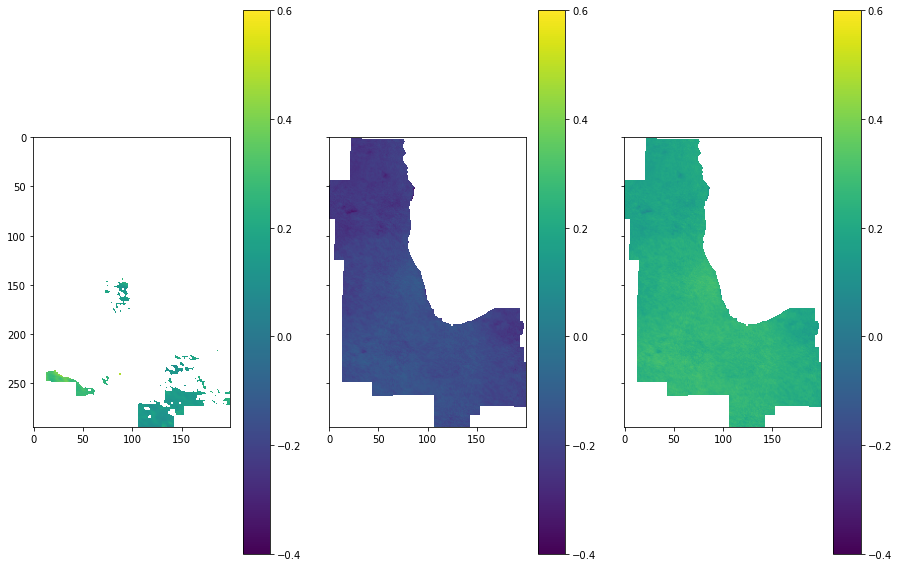

In [223]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 10))
opts = {'vmin': -0.4, 'vmax': 0.6}
im1 = ax1.imshow(padded_data, **opts) # test data
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(padded_pred, **opts) # prediction
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(padded_pred - padded_pred[~np.isnan(padded_pred)].min(), **opts) # prediction shifted st min is zero
plt.colorbar(im3, ax=ax3)
plt.show()

In [292]:
pd.concat([pd.DataFrame(test_data).describe(), pd.DataFrame(test_pred).describe()], axis=1)

,0,0
count,30310.000000,30310.000000
mean,-0.875477,-0.185916
std,0.363190,0.035619
min,-1.000000,-0.415555
25%,-1.000000,-0.213583
50%,-1.000000,-0.180272
75%,-1.000000,-0.157915
max,0.519000,-0.086403


### Predicting individual cells  
Generating individual cell predictions is much the same, but on a smaller scale. Instead of using few, large observations, we use many small observations, which may be easier for the model to fit.

In [266]:
def flattenArray(input):
    """
    Reshapes raster time series into time series of individual cells.
    """
    reshape = np.empty((input.shape[0] * input.shape[2], input.shape[1], 1))
    for i in tqdm(range(input.shape[0])):
        for j in range(input.shape[2]):
            reshape[i * input.shape[2] + j, :, :] = input[i, :, j].reshape(input.shape[1], 1)
    return reshape

In [265]:
windows_flat = flattenArray(windows)
targets_flat = flattenArray(targets)

100%|██████████| 254/254 [00:09<00:00, 25.54it/s]


In [57]:
model_flat = Sequential()
model_flat.add(LSTM(window_length, input_shape=(window_length, 1)))
model_flat.add(Dense(1))
model_flat.compile(loss='mean_squared_error', optimizer='adam')

In [301]:
model_flat.fit(windows_flat, targets_flat, epochs=1, batch_size=512)

15037/15037 [==============================] - 50s 3ms/step - loss: 0.2761


In [302]:
test_pred_flat = model_flat.predict(windows_flat[:30310, :, :]).reshape(30310)

In [303]:
padded_pred_flat = np.full((59000), np.nan)
padded_pred_flat[data.index] = test_pred_flat
padded_pred_flat = padded_pred_flat.reshape(295, 200)

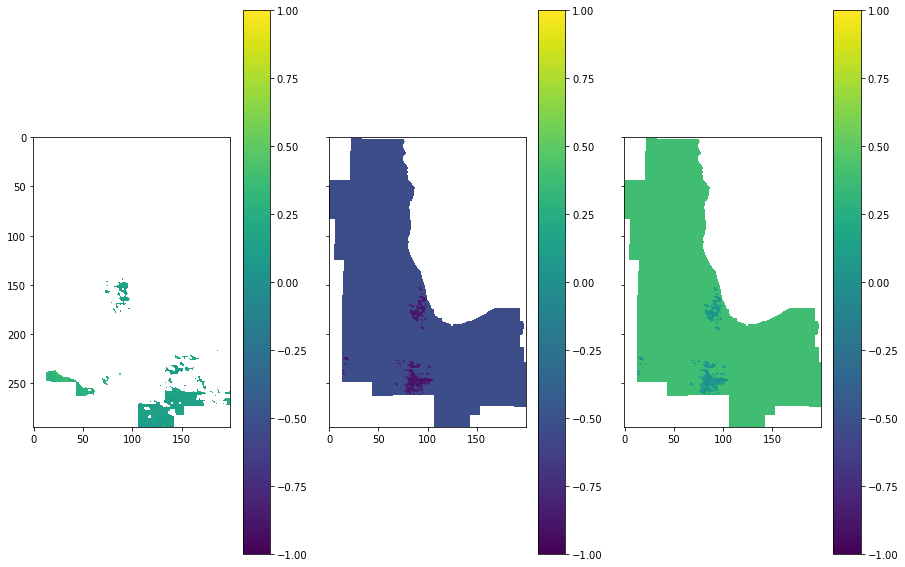

In [304]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 10))
opts = {'vmin': -1, 'vmax': 1}
im1 = ax1.imshow(padded_data, **opts) # test data
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(padded_pred_flat, **opts) # prediction
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(padded_pred_flat - padded_pred_flat[~np.isnan(padded_pred_flat)].min(), **opts) # prediction shifted st min is zero
plt.colorbar(im3, ax=ax3)
plt.show()

In [305]:
pd.concat([pd.DataFrame(test_data).describe(), pd.DataFrame(test_pred_flat).describe()], axis=1)

,0,0
count,30310.000000,30310.000000
mean,-0.875477,-0.535587
std,0.363190,0.053595
min,-1.000000,-0.911473
25%,-1.000000,-0.527345
50%,-1.000000,-0.527345
75%,-1.000000,-0.527345
max,0.519000,-0.168060


## Part 2: Predicting only with populated data

In [8]:
train_sequences = []
pred_sequences = []
for row in tqdm(range(data.shape[0])):
    """
    this loop finds all sequences of at least [window_length] consecutive non-NA entries
    sequences of at least [window_length] can be used for prediction; written to pred_sequences
    sequences of at least [window_length] + 1 can be used for training; written to train_sequences
    """
    for col in range(data.shape[1] - window_length):
        if np.isnan(data.iloc[row, col]):
            continue
        else:
            exists = True
            for i in range(window_length):
                if np.isnan(data.iloc[row, col + i]):
                    exists = False
                    break
            if exists:
                if not np.isnan(data.iloc[row, col + window_length]): # if the value to predict also exists
                    train_sequences.append([row, col])
                pred_sequences.append([row, col])

100%|██████████| 30310/30310 [09:59<00:00, 50.56it/s]


In [9]:
len(train_sequences)

337279

In [10]:
len(pred_sequences)

432154

In [11]:
windows_full = np.empty((len(train_sequences), window_length, 1))
targets_full = np.empty((len(train_sequences), 1, 1))

In [12]:
for idx, seq in tqdm(enumerate(train_sequences)):
    windows_full[idx, :, :] = np.array(data.iloc[seq[0], seq[1]:(seq[1] + window_length)]).transpose().reshape(window_length, windows_full.shape[2])
    targets_full[idx, :, :] = np.array(data.iloc[seq[0], seq[1] + window_length]).transpose().reshape(1, targets_full.shape[2])

337279it [00:46, 7197.20it/s]


In [13]:
np.isnan(windows_full).any()

False

In [14]:
np.isnan(targets_full).any()

False

In [15]:
# reusing structure of model_flat
model_full = Sequential()
model_full.add(LSTM(window_length, input_shape=(window_length, 1)))
model_full.add(Dense(1))
model_full.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
model_full.fit(windows_full, targets_full, epochs=1, batch_size=512)

659/659 [==============================] - 4s 4ms/step - loss: 0.0243


In [17]:
windows_pred = np.empty((len(pred_sequences), window_length, 1))
for idx, seq in tqdm(enumerate(pred_sequences)):
    windows_pred[idx, :, :] = np.array(data.iloc[seq[0], seq[1]:(seq[1] + window_length)]).transpose().reshape(window_length, windows_full.shape[2])

432154it [00:47, 9090.22it/s]


In [18]:
pd.DataFrame(pred_sequences)[1].value_counts()

187    21116
186    19713
224    14621
184    12360
185    12143
       ...  
251       12
111        4
110        4
143        1
145        1
Name: 1, Length: 160, dtype: int64

We will predict using the sequences from column 187 (which predict column 197), as they are most complete.

In [19]:
test_pred_full = model_full.predict(windows_pred[pd.DataFrame(pred_sequences)[1] == 187, :, :]).reshape(21116)

In [20]:
padded_pred_full = np.full((59000), np.nan)
padded_pred_full[data.index[pd.DataFrame(pred_sequences)[pd.DataFrame(pred_sequences)[1] == 187][0]]] = test_pred_full
padded_pred_full = padded_pred_full.reshape(295, 200)

In [23]:
test_data_full = np.array(data.iloc[:, 187 + window_length].fillna(-1))
padded_data_full = np.full((59000), np.nan)
padded_data_full[data.index] = np.where(test_data_full == -1, np.nan, test_data_full)
padded_data_full = padded_data_full.reshape(295, 200)

In [24]:
overwrite = np.array(padded_pred_full.reshape(59000), copy=True)
overwrite[~np.isnan(padded_data_full.reshape(59000))] = padded_data_full.reshape(59000)[~np.isnan(padded_data_full.reshape(59000))]
overwrite = overwrite.reshape(295, 200)

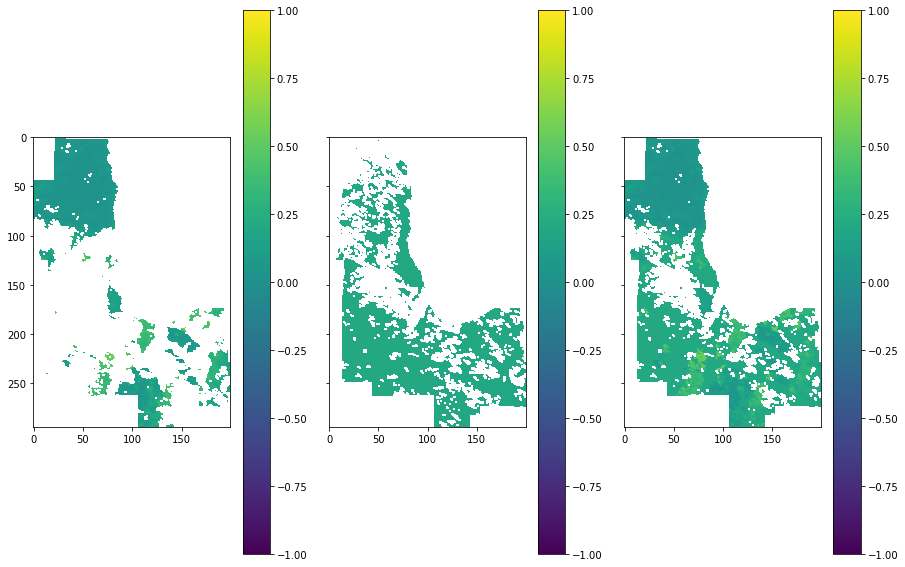

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 10))
opts = {'vmin': -1, 'vmax': 1}
im1 = ax1.imshow(padded_data_full, **opts) # test data
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(padded_pred_full, **opts) # prediction
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(overwrite, **opts) # prediction
plt.colorbar(im3, ax=ax3)

In [28]:
pd.concat([pd.DataFrame(test_data_full[test_data_full != -1]).describe(), pd.DataFrame(test_pred_full).describe()], axis=1)

,0,0
count,12881.000000,21116.000000
mean,0.146237,0.206002
std,0.133485,0.004294
min,0.010310,0.191947
25%,0.045516,0.202831
50%,0.089803,0.205735
75%,0.217689,0.209121
max,0.597000,0.221818


We observe that this model doesn't have as much variation as we would expect, compared to the test data. We will now make some improvements to the model, namely adding dropout layers, which reduce overfitting by selectively ignoring data points, and by using a train/test split.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(windows_full, targets_full, random_state=1312)

In [67]:
stopper = EarlyStopping(patience=10, restore_best_weights=True)

In [68]:
# overwriting model_full; note dropout argument to LSTM layer
model_full = Sequential()
model_full.add(LSTM(window_length, input_shape=(window_length, 1), dropout=0.2))
model_full.add(Dense(1))
model_full.compile(loss='mean_squared_error', optimizer='adam')

In [69]:
model_full.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test), callbacks=[stopper])

Epoch 1/100
15810/15810 [==============================] - 39s 2ms/step - loss: 0.0226 - val_loss: 0.0215
Epoch 2/100
15810/15810 [==============================] - 37s 2ms/step - loss: 0.0219 - val_loss: 0.0205
Epoch 3/100
15810/15810 [==============================] - 38s 2ms/step - loss: 0.0212 - val_loss: 0.0201
Epoch 4/100
15810/15810 [==============================] - 39s 2ms/step - loss: 0.0208 - val_loss: 0.0196
Epoch 5/100
15810/15810 [==============================] - 39s 2ms/step - loss: 0.0204 - val_loss: 0.0194
Epoch 6/100
15810/15810 [==============================] - 39s 2ms/step - loss: 0.0201 - val_loss: 0.0194
Epoch 7/100
15810/15810 [==============================] - 38s 2ms/step - loss: 0.0199 - val_loss: 0.0190
Epoch 8/100
15810/15810 [==============================] - 38s 2ms/step - loss: 0.0197 - val_loss: 0.0189
Epoch 9/100
15810/15810 [==============================] - 38s 2ms/step - loss: 0.0195 - val_loss: 0.0190
Epoch 10/100
15810/15810 [====================

In [70]:
test_pred_full = model_full.predict(windows_pred[pd.DataFrame(pred_sequences)[1] == 187, :, :]).reshape(21116)

In [71]:
padded_pred_full = np.full((59000), np.nan)
padded_pred_full[data.index[pd.DataFrame(pred_sequences)[pd.DataFrame(pred_sequences)[1] == 187][0]]] = test_pred_full
padded_pred_full = padded_pred_full.reshape(295, 200)

In [72]:
overwrite = np.array(padded_pred_full.reshape(59000), copy=True)
overwrite[~np.isnan(padded_data_full.reshape(59000))] = padded_data_full.reshape(59000)[~np.isnan(padded_data_full.reshape(59000))]
overwrite = overwrite.reshape(295, 200)

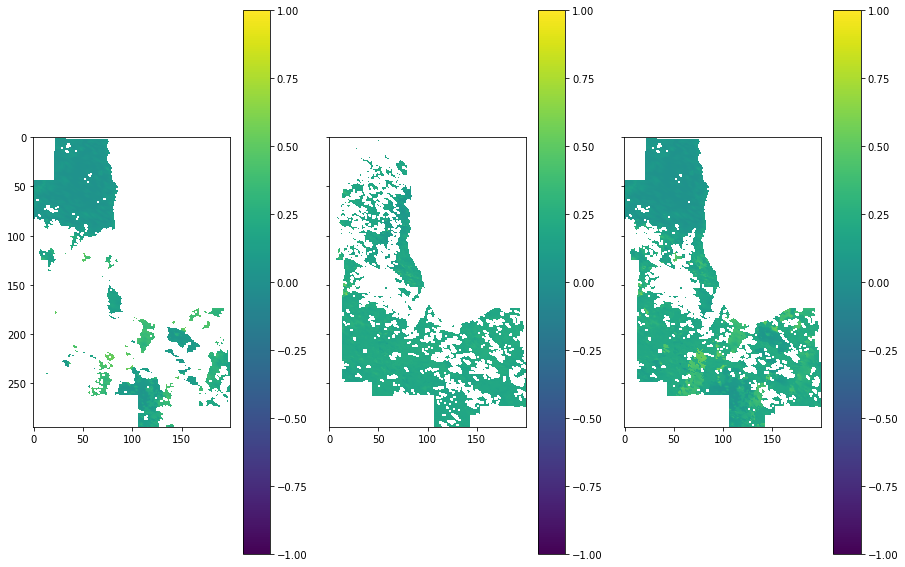

In [73]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 10))
opts = {'vmin': -1, 'vmax': 1}
im1 = ax1.imshow(padded_data_full, **opts) # test data
plt.colorbar(im1, ax=ax1)/
im2 = ax2.imshow(padded_pred_full, **opts) # prediction
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(overwrite, **opts) # prediction
plt.colorbar(im3, ax=ax3)

In [74]:
pd.concat([pd.DataFrame(test_data_full[test_data_full != -1]).describe(), pd.DataFrame(test_pred_full).describe()], axis=1)

,0,0
count,12881.000000,21116.000000
mean,0.146237,0.195925
std,0.133485,0.038669
min,0.010310,0.029083
25%,0.045516,0.178445
50%,0.089803,0.196641
75%,0.217689,0.216828
max,0.597000,0.705543


Will now test to see if results hold at shorter windows. Most of the following code is copied verbatim from the previous sections.

In [75]:
window_length = 5

In [76]:
train_sequences = []
pred_sequences = []
for row in tqdm(range(data.shape[0])):
    """
    this loop finds all sequences of at least [window_length] consecutive non-NA entries
    sequences of at least [window_length] can be used for prediction; written to pred_sequences
    sequences of at least [window_length] + 1 can be used for training; written to train_sequences
    """
    for col in range(data.shape[1] - window_length):
        if np.isnan(data.iloc[row, col]):
            continue
        else:
            exists = True
            for i in range(window_length):
                if np.isnan(data.iloc[row, col + i]):
                    exists = False
                    break
            if exists:
                if not np.isnan(data.iloc[row, col + window_length]): # if the value to predict also exists
                    train_sequences.append([row, col])
                pred_sequences.append([row, col])

100%|██████████| 30310/30310 [09:25<00:00, 53.58it/s]


In [77]:
len(train_sequences)

1214692

In [78]:
len(pred_sequences)

1597401

In [79]:
windows_full = np.empty((len(train_sequences), window_length, 1))
targets_full = np.empty((len(train_sequences), 1, 1))

In [80]:
for idx, seq in tqdm(enumerate(train_sequences)):
    windows_full[idx, :, :] = np.array(data.iloc[seq[0], seq[1]:(seq[1] + window_length)]).transpose().reshape(window_length, windows_full.shape[2])
    targets_full[idx, :, :] = np.array(data.iloc[seq[0], seq[1] + window_length]).transpose().reshape(1, targets_full.shape[2])

1214692it [02:50, 7134.65it/s]


In [81]:
windows_pred = np.empty((len(pred_sequences), window_length, 1))
for idx, seq in tqdm(enumerate(pred_sequences)):
    windows_pred[idx, :, :] = np.array(data.iloc[seq[0], seq[1]:(seq[1] + window_length)]).transpose().reshape(window_length, windows_full.shape[2])

1597401it [02:54, 9158.87it/s]


In [82]:
X_train, X_test, y_train, y_test = train_test_split(windows_full, targets_full, random_state=1312)

In [83]:
stopper = EarlyStopping(patience=10, restore_best_weights=True)

In [86]:
# model with dropout
model_full = Sequential()
model_full.add(LSTM(window_length, input_shape=(window_length, 1), dropout=0.2))
model_full.add(Dense(1))
model_full.compile(loss='mean_squared_error', optimizer='adam')

In [90]:
model_full.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[stopper])

Epoch 1/100
28470/28470 [==============================] - 48s 2ms/step - loss: 0.0243 - val_loss: 0.0234
Epoch 2/100
28470/28470 [==============================] - 47s 2ms/step - loss: 0.0238 - val_loss: 0.0230
Epoch 3/100
28470/28470 [==============================] - 50s 2ms/step - loss: 0.0233 - val_loss: 0.0227
Epoch 4/100
28470/28470 [==============================] - 50s 2ms/step - loss: 0.0230 - val_loss: 0.0222
Epoch 5/100
28470/28470 [==============================] - 48s 2ms/step - loss: 0.0227 - val_loss: 0.0223
Epoch 6/100
28470/28470 [==============================] - 50s 2ms/step - loss: 0.0225 - val_loss: 0.0218
Epoch 7/100
28470/28470 [==============================] - 51s 2ms/step - loss: 0.0223 - val_loss: 0.0216
Epoch 8/100
28470/28470 [==============================] - 50s 2ms/step - loss: 0.0222 - val_loss: 0.0215
Epoch 9/100
28470/28470 [==============================] - 51s 2ms/step - loss: 0.0221 - val_loss: 0.0219
Epoch 10/100
28470/28470 [====================

In [91]:
pd.DataFrame(pred_sequences)[1].value_counts()

116    26947
19     26904
65     25458
192    25222
187    24799
       ...  
148        5
100        5
110        4
111        4
112        4
Name: 1, Length: 200, dtype: int64

In [93]:
test_pred_full = model_full.predict(windows_pred[pd.DataFrame(pred_sequences)[1] == 187, :, :]).reshape(24799)

In [94]:
padded_pred_full = np.full((59000), np.nan)
padded_pred_full[data.index[pd.DataFrame(pred_sequences)[pd.DataFrame(pred_sequences)[1] == 187][0]]] = test_pred_full
padded_pred_full = padded_pred_full.reshape(295, 200)

In [95]:
overwrite = np.array(padded_pred_full.reshape(59000), copy=True)
overwrite[~np.isnan(padded_data_full.reshape(59000))] = padded_data_full.reshape(59000)[~np.isnan(padded_data_full.reshape(59000))]
overwrite = overwrite.reshape(295, 200)

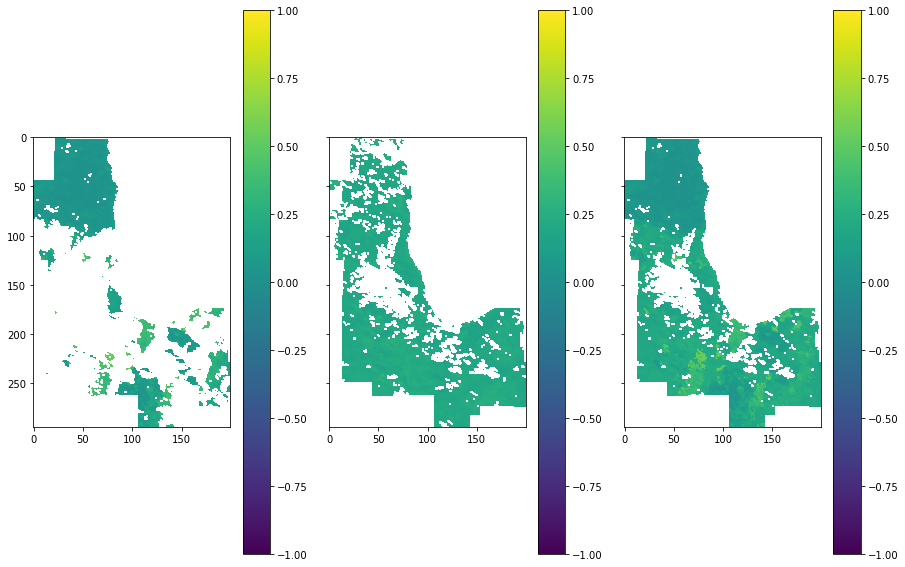

In [97]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 10))
opts = {'vmin': -1, 'vmax': 1}
im1 = ax1.imshow(padded_data_full, **opts) # test data
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(padded_pred_full, **opts) # prediction
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(overwrite, **opts) # prediction
plt.colorbar(im3, ax=ax3)

In [98]:
pd.concat([pd.DataFrame(test_data_full[test_data_full != -1]).describe(), pd.DataFrame(test_pred_full).describe()], axis=1)

,0,0
count,12881.000000,24799.000000
mean,0.146237,0.207545
std,0.133485,0.028124
min,0.010310,0.099766
25%,0.045516,0.187973
50%,0.089803,0.207040
75%,0.217689,0.226349
max,0.597000,0.386239


### Bidirectional LSTM
Now I'll extend to a bidirectional LSTM (forward and backward prediction). For this, we will need new windows; for this section, the window_length parameter will be treated as the length on each side of a given point, meaning that in this case, predictions will be made using the previous 5 and next 5 data points.  
First, we will need to find windows where such data exists.

In [108]:
train_sequences = []
pred_sequences = []
pred_window = list(range(window_length * 2 + 1)) # 2 * window_length + 1 list with the middle removed
pred_window.remove(window_length)
for row in tqdm(range(data.shape[0])):
    """
    this loop finds all instances of data points bordered by sequences of [window_length] consecutive non-NA entries
    sequences where the surrounded point is NA can be used for prediction; written to pred_sequences
    sequences where the surrounded point is non-NA can be used for training; written to train_sequences
    """
    for col in range(data.shape[1] - window_length * 2):
        if np.isnan(data.iloc[row, col]):
            continue
        else:
            exists = True
            for i in pred_window:
                if np.isnan(data.iloc[row, col + i]):
                    exists = False
                    break
            if exists:
                if not np.isnan(data.iloc[row, col + window_length]): # if the value to predict also exists
                    train_sequences.append([row, col])
                pred_sequences.append([row, col])

100%|██████████| 30310/30310 [10:11<00:00, 49.55it/s]


In [110]:
len(train_sequences)

337279

In [111]:
len(pred_sequences)

456409

In [112]:
windows_bi = np.empty((len(train_sequences), window_length * 2, 1))
targets_bi = np.empty((len(train_sequences), 1, 1))

In [136]:
for idx, seq in tqdm(enumerate(train_sequences)):
    windows_bi[idx, :, :] = np.array(data.iloc[seq[0], seq[1] + np.array(pred_window)]).transpose().reshape(window_length * 2, windows_bi.shape[2])
    targets_bi[idx, :, :] = np.array(data.iloc[seq[0], seq[1] + window_length]).transpose().reshape(1, windows_bi.shape[2])

337279it [01:01, 5517.18it/s]


In [130]:
windows_pred = np.empty((len(pred_sequences), window_length * 2, 1))
for idx, seq in tqdm(enumerate(pred_sequences)):
    windows_pred[idx, :, :] = np.array(data.iloc[seq[0], seq[1] + np.array(pred_window)]).transpose().reshape(window_length * 2, windows_bi.shape[2])

456409it [01:09, 6596.23it/s]


In [139]:
X_train, X_test, y_train, y_test = train_test_split(windows_bi, targets_bi, random_state=1312)

In [132]:
stopper = EarlyStopping(patience=10, restore_best_weights=True)

In [140]:
model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(window_length * 2, input_shape=(window_length, 1), dropout=0.2)))
model_bi.add(Dense(1))
model_bi.compile(loss='mean_squared_error', optimizer='adam')

In [141]:
model_bi.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test), callbacks=[stopper])

Epoch 1/100
15810/15810 [==============================] - 49s 3ms/step - loss: 0.0218 - val_loss: 0.0216
Epoch 2/100
15810/15810 [==============================] - 47s 3ms/step - loss: 0.0215 - val_loss: 0.0214
Epoch 3/100
15810/15810 [==============================] - 47s 3ms/step - loss: 0.0214 - val_loss: 0.0212
Epoch 4/100
15810/15810 [==============================] - 48s 3ms/step - loss: 0.0212 - val_loss: 0.0210
Epoch 5/100
15810/15810 [==============================] - 48s 3ms/step - loss: 0.0209 - val_loss: 0.0204
Epoch 6/100
15810/15810 [==============================] - 48s 3ms/step - loss: 0.0204 - val_loss: 0.0199
Epoch 7/100
15810/15810 [==============================] - 48s 3ms/step - loss: 0.0200 - val_loss: 0.0200
Epoch 8/100
15810/15810 [==============================] - 51s 3ms/step - loss: 0.0197 - val_loss: 0.0196
Epoch 9/100
15810/15810 [==============================] - 53s 3ms/step - loss: 0.0195 - val_loss: 0.0198
Epoch 10/100
15810/15810 [====================

In [147]:
test_pred_bi = model_bi.predict(windows_pred[pd.DataFrame(pred_sequences)[1] == 187, :, :]).reshape(8729)

In [148]:
padded_pred_bi = np.full((59000), np.nan)
padded_pred_bi[data.index[pd.DataFrame(pred_sequences)[pd.DataFrame(pred_sequences)[1] == 187][0]]] = test_pred_bi
padded_pred_bi = padded_pred_bi.reshape(295, 200)

In [152]:
overwrite = np.array(padded_pred_bi.reshape(59000), copy=True)
overwrite[~np.isnan(padded_data_full.reshape(59000))] = padded_data_full.reshape(59000)[~np.isnan(padded_data_full.reshape(59000))]
overwrite = overwrite.reshape(295, 200)

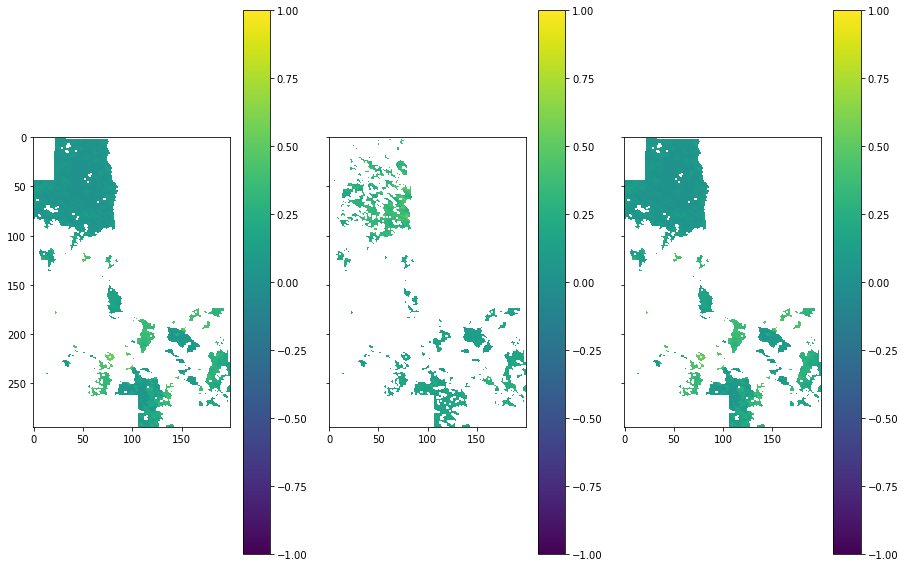

In [150]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 10))
opts = {'vmin': -1, 'vmax': 1}
im1 = ax1.imshow(padded_data_full, **opts) # test data
plt.colorbar(im1, ax=ax1)
im2 = ax2.imshow(padded_pred_bi, **opts) # prediction
plt.colorbar(im2, ax=ax2)
im3 = ax3.imshow(overwrite, **opts) # prediction
plt.colorbar(im3, ax=ax3)

In [155]:
np.any(overwrite == padded_data_full)

True

In [156]:
pd.concat([pd.DataFrame(test_data_full[test_data_full != -1]).describe(), pd.DataFrame(test_pred_bi).describe()], axis=1)

,0,0
count,12881.000000,8729.000000
mean,0.146237,0.239700
std,0.133485,0.087302
min,0.010310,0.059596
25%,0.045516,0.172819
50%,0.089803,0.218512
75%,0.217689,0.303580
max,0.597000,0.584461
